# YOLO Food Detection Training


**Note:** For fast training, it's best to use a GPU runtime in Google Colab. You can upload this notebook to your Colab environment.

## Step 0: Environment Setup

**IMPORTANT**: Make sure to enable GPU runtime!
- Go to: **Runtime > Change runtime type > Hardware accelerator > GPU**
- Choose **T4 GPU** (free tier).


In [ ]:
# Check GPU availability
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("No GPU detected - please enable GPU runtime!")

In [1]:
!pip install ultralytics -q

You should consider upgrading via the '/Users/zoe/Downloads/ai-food-tracker/venv/bin/python3 -m pip install --upgrade pip' command.


In [2]:
# Import libraries
import os
import json
import time
import shutil
import yaml
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from tqdm import tqdm
from pathlib import Path
from ultralytics import YOLO
from IPython.display import display, Image, clear_output
from concurrent.futures import ThreadPoolExecutor

# Suppress warnings
warnings.filterwarnings('ignore')

## Step 1: Prepare food image dataset

Instead of using the full 3GB dataset, the following cells focus on the smaller dataset (375MB) from the [dataset-ninja website](https://datasetninja.com/food-recognition).

In [ ]:
import os
import tarfile
from tqdm import tqdm


def download_and_extract(dataset_type="sample", extract_dir="/content/extracted_food_recognition"):

    urls = {
        "full": "https://assets.supervisely.com/remote/eyJsaW5rIjogImZzOi8vYXNzZXRzLzk1MF9Gb29kIFJlY29nbml0aW9uIDIwMjIvZm9vZC1yZWNvZ25pdGlvbi0yMDIyLURhdGFzZXROaW5qYS50YXIiLCAic2lnIjogIlpqZisyZURmaEoyZkhWNGRiTHBPWkEzN0NodWhlb28wNlZlQXpQQkdBc1U9In0=",
        "sample": "https://assets.supervisely.com/supervisely-supervisely-assets-public/teams_storage/Y/I/Yu/V12n4DX73dwmLY7sz7Bl83qOdACZBbaB9ctVmlEUPBx1qqaqLqnHsLubJQWGAKu3vrqBPty6hRBOrUaXzgPe1jMk7bI1MVcWCNON9vbLeZdPKuRV9Psis3STGSh7.tar"
    }

    if dataset_type not in urls:
        raise ValueError("dataset_type must be either 'full' or 'sample'")

    url = urls[dataset_type]
    tar_path = f"/content/{dataset_type}_food_dataset.tar"

    print(f"Downloading [{dataset_type}] dataset...")
    !wget -q --show-progress -O "$tar_path" "$url"

    if os.path.exists(extract_dir):
        print(f"{extract_dir} already exists. Skipping extraction.")
        return
    
    with tarfile.open(tar_path, "r") as tar:
        members = tar.getmembers()
        for member in tqdm(members, desc="Extracting"):
            tar.extract(member, path=extract_dir)
            

    print(f"Dataset extracted to {extract_dir}")

download_and_extract("sample")

### Optional: Use dataset-tools for downloading.

In [ ]:
# Note: No need to run this cell if you have already downloaded the dataset.

!pip install dataset-tools

import os
import dataset_tools as dtools

drive_path = 'content/datasets/FoodRecognition2022'
marker_file = os.path.join(drive_path, 'meta.json')  

if not os.path.exists(marker_file):
    print("Downloading dataset...")
    # It will handle the extraction of the dataset automatically.
    dtools.download(dataset='Food Recognition 2022', dst_dir=drive_path)
else:
    print("Dataset already exists.")

## Step2: Training Preparation

### Filter category with a small number of training images


#### 1. Avaliable categories:

The class/food category names that are detected in this image dataset can be found in the file `meta.json`:

```json
{
    "classes": [
        {
            "title": "bread-wholemeal",
            "shape": "polygon",
            "color": "#0F8A39",
            "geometry_config": {},
            "id": 3415,
            "hotkey": ""
        },
        {
            "title": "jam",
            "shape": "polygon",
            "color": "#8A460F",
            "geometry_config": {},
            "id": 3417,
            "hotkey": ""
        }
        ...
    ]
}
```

#### 2. Imbalanced food class distribution

You can check the food class distribution in [this section](https://datasetninja.com/food-recognition#class-balance).

To improve training efficiency, for categories that have fewer than 30 images, this project will skip these categories.

In [7]:
# hard code the excluded food categories with less than 30 images
excluded_food_categories = set([
    "oil",
    "tea-spice",
    "tea-fruit",
    "tea-ginger",
    "tea-rooibos",
    "chocolate-filled",
    "light-beer",
    "bagel-without-filling",
    "oat-milk",
    "buckwheat-pancake",
    "gummi-bears-fruit-jellies-jelly-babies-with-fruit-essence",
    "corn-flakes",
    "ice-cubes",
    "black-forest-tart",
    "m-m-s",
    "chocolate-milk-chocolate-drink",
    "cake-marble",
    "cake-salted",
    "mango-dried",
    "blackberry",
    "italian-salad-dressing",
    "soup-potato",
    "brazil-nut",
    "pastry-flaky",
    "champagne",
    "macaroon",
    "dumplings",
    "sekt",
    "soya-drink-soy-milk",
    "soya-yaourt-yahourt-yogourt-ou-yoghourt",
    "chorizo",
    "turnover-with-meat-small-meat-pie-empanadas",
    "white-chocolate",
    "margarine",
    "mix-of-dried-fruits-and-nuts",
    "white-radish",
    "grissini",
    "apricot-dried",
    "smoked-cooked-sausage-of-pork-and-beef-meat-sausag",
    "soup-cream-of-vegetables",
    "prosecco",
    "soup-miso",
    "kebab-in-pita-bread",
    "mushroom-average-stewed-without-addition-of-fat-without-addition-of-salt",
    "cooked-sausage",
    "sugar-glazing",
    "maple-syrup-concentrate",
    "philadelphia",
    "aperitif-with-alcohol-aperol-spritz",
    "damson-plum",
    "pie-rhubarb-baked-with-cake-dough",
    "linseeds",
    "lasagne-vegetable-prepared",
    "milk-chocolate-with-hazelnuts",
    "popcorn-salted",
    "rice-jasmin",
    "faux-mage-cashew-vegan-chers",
    "croque-monsieur",
    "tomato-stewed-without-addition-of-fat-without-addition-of-salt",
    "cocoa-powder",
    "perch-fillets-lake",
    "soup-tomato",
    "ham-turkey",
    "fruit-compotes",
    "french-pizza-from-alsace-baked",
    "banana-cake",
    "balsamic-vinegar",
    "eggplant-caviar",
    "naan-indien-bread",
    "chocolate-egg-small",
    "cake-oblong",
    "biscuit-with-butter",
    "pecan-nut",
    "savoury-puff-pastry-stick",
    "sweets-candies",
    "coriander",
    "fish-crunchies-battered",
    "chia-grains",
    "minced-meat",
    "bean-seeds",
    "meat-balls",
    "bouillon-vegetable",
    "coffee-decaffeinated",
    "carrot-cake",
    "paprika-chips",
    "lemon-pie",
    "fig-dried",
    "waffle"
])

In [8]:
def load_and_filter_classes(drive_path, excluded_set):
    """
    Loads class names from meta.json and filters them based on the hardcoded
    EXCLUDED_CATEGORIES set.
    """
    # 1. Load all original class names
    meta_path = os.path.join(drive_path, 'meta.json')
    if not os.path.exists(meta_path):
        raise FileNotFoundError(f"meta.json not found at {meta_path}")
    with open(meta_path, 'r') as f:
        meta_data = json.load(f)
    original_class_names = [cls['title'] for cls in meta_data.get('classes', [])]
    print(f"Loaded {len(original_class_names)} total classes from meta.json")
    
    # 2. Filter classes using the provided exclusion set
    filtered_class_names = [
        name for name in original_class_names if name not in excluded_set
    ]
    num_removed = len(original_class_names) - len(filtered_class_names)
    print(f"Removed {num_removed} specified rare classes.")
    print(f"Kept {len(filtered_class_names)} classes for training.")

    # 3. Create a new class map for only the filtered classes
    filtered_class_map = {name: i for i, name in enumerate(filtered_class_names)}

    return filtered_class_names, filtered_class_map

In [10]:
extract_dir = "/content/extracted_food_recognition"

class_names, class_map = load_and_filter_classes(extract_dir, excluded_food_categories)

Loaded 498 total classes from meta.json
Removed 88 specified rare classes.
Kept 410 classes for training.


### Convert annotation json to yolo detection bounding box

For example, for `training/img/006497.jpg`, annotations can be found in the relevant annotation folder: `training/ann/006497.jpg.json`

However, YOLO needs a label file in text format.

You can use this image ([Source]((https://github.com/ultralytics/docs/releases/download/0/two-persons-tie.avif))) to better understand how it works: 

![yolo sample img](https://github.com/ultralytics/docs/releases/download/0/two-persons-tie.avif) 

The corresponding label text is as follws:

```txt
0 0.481719 0.634028 0.690625 0.713278
0 0.741094 0.524306 0.314750 0.933389
27 0.364844 0.795833 0.078125 0.400000
```

- The first column (`0`) is the category ID. In this case, `0` refers to `Person`. 
- The second (`0.481719`) and third columns (`0.634028`) are used as x,y central point coordinates of this object. 
- The fourth(`0.690625`) and fifth columns(`0.713278`) represent the width and height of the object.


For more information, you can check [this documentation](link).

**Note:** In our project, the original ID in `meta.json` is not used. The `class_map` returns a unique integer ID as the key.

In [26]:
def convert_annotations(split_name, class_map):
    print(f"\nGenerating labels for {split_name} split using {len(class_map)} classes...")

    split_dir = os.path.join(extract_dir, split_name)
    original_ann_dir = os.path.join(split_dir, 'ann')
    original_img_dir = os.path.join(split_dir, 'img')

    yolo_label_dir = os.path.join(split_dir, 'labels')
    os.makedirs(yolo_label_dir, exist_ok=True)

    if not os.path.isdir(original_ann_dir):
        print(f"Warning: Annotation dir not found: {original_ann_dir}. Skipping.")
        return

    ann_files = [f for f in os.listdir(original_ann_dir) if f.endswith('.json')]

    valid_labels = 0
    empty_labels = 0

    for ann_file in tqdm(ann_files, desc=f'Converting {split_name} annotations'):
        json_path = os.path.join(original_ann_dir, ann_file)
        with open(json_path, 'r') as f:
            data = json.load(f)

        if ann_file.endswith('.jpg.json'):
            base_filename = ann_file.replace('.jpg.json', '')
            img_extensions = ['.jpg', '.jpeg', '.png', '.JPG']
        else:
            base_filename = ann_file.replace('.json', '')
            img_extensions = ['.jpg', '.jpeg', '.png', '.JPG']

        img_path = None
        for ext in img_extensions:
            potential_path = os.path.join(original_img_dir, f"{base_filename}{ext}")
            if os.path.exists(potential_path):
                img_path = potential_path
                break

        if not img_path:
            print(f"Warning: No image found for {ann_file}")
            continue

        yolo_lines = []
        img_h, img_w = data['size']['height'], data['size']['width']
        if img_h == 0 or img_w == 0:
            continue

        for obj in data['objects']:
            class_title = obj['classTitle']
            if class_title not in class_map:
                continue
            class_id = class_map[class_title]
            points = np.array(obj['points']['exterior'])
            if points.shape[0] < 1:
                continue
            x_min, y_min = points.min(axis=0)
            x_max, y_max = points.max(axis=0)
            box_w, box_h = x_max - x_min, y_max - y_min
            x_center, y_center = x_min + box_w / 2, y_min + box_h / 2
            x_norm, y_norm, w_norm, h_norm = x_center / img_w, y_center / img_h, box_w / img_w, box_h / img_h
            yolo_lines.append(f"{class_id} {x_norm:.6f} {y_norm:.6f} {w_norm:.6f} {h_norm:.6f}")

        if yolo_lines:
            with open(os.path.join(yolo_label_dir, f"{base_filename}.txt"), 'w') as f:
                f.write('\n'.join(yolo_lines))
            valid_labels += 1
        else:
            empty_labels += 1

    print(f"Created {valid_labels} valid label files, {empty_labels} images had no valid annotations")

In [27]:
convert_annotations("training", class_map)
convert_annotations("validation", class_map)


Generating labels for training split using 410 classes...


Converting training annotations:   0%|          | 0/4654 [00:00<?, ?it/s]

Converting training annotations:  34%|███▍      | 1589/4654 [00:00<00:00, 3368.76it/s]

Converting training annotations:  82%|████████▏ | 3810/4654 [00:01<00:00, 3374.46it/s]

Converting training annotations: 100%|██████████| 4654/4654 [00:01<00:00, 3388.38it/s]


Created 4269 valid label files, 381 images had no valid annotations

Generating labels for validation split using 410 classes...


Converting validation annotations: 100%|██████████| 147/147 [00:00<00:00, 1842.71it/s]

Created 125 valid label files, 22 images had no valid annotations


### Prepare the dataset.yaml

For YOLO training, it's important to let YOLO know your training target. In our case, these are food categories that can be found in our image datasets, as well as the path of our training/validation dataset.

In [28]:
dataset_yaml_path = os.path.join(extract_dir, 'dataset.yaml')

final_class_names = list(class_map.keys())
yaml_content = {
    'path': extract_dir,
    'train': os.path.join('training', 'img'),
    'val': os.path.join('validation', 'img'),
    'nc': len(final_class_names),
    'names': final_class_names
}
with open(dataset_yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, sort_keys=False)

print(f"`dataset.yaml` created at: {dataset_yaml_path}")

`dataset.yaml` created at: sample_data/dataset.yaml


## Step 3: Start Training

In [31]:
# TBD: update the parameter setting using colab file
class FoodDetectionTrainer:

    def __init__(self, dataset_path, model_size='n'):

        self.dataset_path = dataset_path
        self.model_size = model_size
        self.model_map = {
            'n': 'yolov8n.pt',    # Nano - fastest, smallest
            's': 'yolov8s.pt',    # Small - balanced
            'm': 'yolov8m.pt',    # Medium - better accuracy
            'l': 'yolov8l.pt',    # Large - high accuracy
            'x': 'yolov8x.pt'     # Extra Large - highest accuracy
        }
        
        # Validate the dataset upon initialization
        self.validate_dataset()
        
    def validate_dataset(self):
        """Validates the dataset structure and files."""
        
        # Check for dataset.yaml
        yaml_path = os.path.join(self.dataset_path, 'dataset.yaml')
        if not os.path.exists(yaml_path):
            raise FileNotFoundError(f"dataset.yaml not found in {self.dataset_path}")
        
        # Load configuration
        with open(yaml_path, 'r') as f:
            config = yaml.safe_load(f)
        
        self.config = config
        self.num_classes = config['nc']
        print(f"Detected {self.num_classes} food categories.")
        
        # Check training and validation sets
        base_path = config.get('path', self.dataset_path)
        train_img_path = os.path.join(base_path, config['train'])
        val_img_path = os.path.join(base_path, config['val'])
        
        for split_name, img_path in [('Training set', train_img_path), ('Validation set', val_img_path)]:
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"{split_name} image directory not found: {img_path}")
            
            # Infer label path from image path
            label_path = os.path.join(os.path.dirname(img_path), 'labels')
            if not os.path.exists(label_path):
                raise FileNotFoundError(f"{split_name} label directory not found: {label_path}")
            
            # Count files
            img_files = [f for f in os.listdir(img_path) 
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            label_files = [f for f in os.listdir(label_path) if f.endswith('.txt')]
            
            print(f"  {split_name}: {len(img_files)} images, {len(label_files)} label files.")
            
            valid_labels = 0
            empty_labels = 0
            for label_file in label_files[:min(50, len(label_files))]:
                with open(os.path.join(label_path, label_file), 'r') as f:
                    content = f.read().strip()
                    if content:
                        valid_labels += 1
                    else:
                        empty_labels += 1
            
            print(f"    Sampled Quality - Valid labels: {valid_labels}, Empty labels: {empty_labels}")
        
    
    def setup_training_config(self, epochs=100, batch_size=16, image_size=640, 
                            learning_rate=0.01, patience=50):
        
        if self.num_classes > 200: 
            recommended_epochs = max(100, min(200, self.num_classes // 2))
            recommended_batch = min(batch_size, 32)  
            recommended_lr = min(learning_rate, 0.01)  
        else:
            recommended_epochs = epochs
            recommended_batch = batch_size
            recommended_lr = learning_rate
        
        self.training_config = {
            'epochs': 50, #TD
            'batch': recommended_batch,
            'imgsz': image_size,
            'lr0': recommended_lr,
            'patience': patience,
            'device': "0" if torch.cuda.is_available() else "cpu",
            'workers': 8,       
            'cache': 'disk',    
            'amp': True,        
            'optimizer': 'AdamW',
            'weight_decay': 0.0005,
            'warmup_epochs': 5,
            'warmup_momentum': 0.8,
            'warmup_bias_lr': 0.1,
            'mosaic': 0.5,      # Data augmentation
            'mixup': 0.0,
            'copy_paste': 0.1,
            'degrees': 5.0,    # Rotation
            'translate': 0.2,   # Translation
            'scale': 0.5,       # Scale
            'fliplr': 0.5,      # Horizontal flip
            'flipud': 0.0,      # Vertical flip (food is rarely upside down)
            'hsv_h': 0.005,     # HSV-Hue augmentation
            'hsv_s': 0.3,       # HSV-Saturation augmentation
            'hsv_v': 0.3,       # HSV-Value augmentation
        }
        
        
        return self.training_config
    
    def train(self, project_name='food_detection', experiment_name=None):
        
        if experiment_name is None:
            experiment_name = f'food_detection_{self.model_size}_{self.num_classes}classes'
        
        print(f"\n Starting food detection model training...")
        print(f" Project: {project_name}")
        print(f"Experiment: {experiment_name}")
        
        # Load model
        model = YOLO(self.model_map[self.model_size])
        print(f"Loaded {self.model_map[self.model_size]} pretrained model.")
        
        # Start training
        dataset_yaml = os.path.join(self.dataset_path, 'dataset.yaml')
        
        try:
            results = model.train(
                data=dataset_yaml,
                project=f'runs/detect/{project_name}',
                name=experiment_name,
                exist_ok=True,
                plots=True,
                save_json=True,
                val=True,
                verbose=True,
                **self.training_config
            )
            
            self.results = results
            self.model = model
            
            return results
            
        except Exception as e:
            print(f"An error occurred during training: {e}")
            raise
    
    def evaluate(self):
        if not hasattr(self, 'results'):
            print("Please complete training before evaluating!")
            return
        
        # Run validation
        dataset_yaml = os.path.join(self.dataset_path, 'dataset.yaml')
        val_results = self.model.val(data=dataset_yaml, plots=True, save_json=True)
        
        # Display main metrics
        metrics = {
            'mAP50': val_results.box.map50,
            'mAP50-95': val_results.box.map,
            'Precision': val_results.box.mp,
            'Recall': val_results.box.mr
        }
        
        print(f"   mAP@0.5: {metrics['mAP50']:.4f} ({metrics['mAP50']*100:.1f}%)")
        print(f"   mAP@0.5:0.95: {metrics['mAP50-95']:.4f} ({metrics['mAP50-95']*100:.1f}%)")
        print(f"   Precision: {metrics['Precision']:.4f} ({metrics['Precision']*100:.1f}%)")
        print(f"   Recall: {metrics['Recall']:.4f} ({metrics['Recall']*100:.1f}%)")
        
        # Performance feedback
        if metrics['mAP50'] > 0.7:
            print("\n Excellent.")
        elif metrics['mAP50'] > 0.5:
            print("\n Great.")
        elif metrics['mAP50'] > 0.3:
            print("\n Fair.")
        else:
            print("\n Needs Improvement.")
        
        return val_results
    
    def visualize_results(self):
        if not hasattr(self, 'results'):
            print("Please complete training before visualizing results!")
            return
        
        results_dir = self.results.save_dir
        
        # Display training plots
        plots = [
            ('results.png', 'Training Curves'),
            ('confusion_matrix.png', 'Confusion Matrix'),
            ('labels.jpg', 'Label Distribution'),
            ('val_batch0_pred.jpg', 'Validation Prediction Sample')
        ]
        
        for filename, title in plots:
            filepath = os.path.join(results_dir, filename)
            if os.path.exists(filepath):
                print(f"\n{title}:")
                try:
                    display(Image(filepath))
                except Exception as e:
                    print(f"Could not display {filename}: {e}")
            else:
                print(f"{filename} not found.")
    
    def test_prediction(self, test_image_path, confidence=0.25):
        """Tests a prediction on a single image."""
        if not hasattr(self, 'model'):
            print("Please complete training before testing!")
            return
        
        print(f"Predicting on image: {test_image_path}")
        
        # Make prediction
        results = self.model.predict(
            test_image_path,
            conf=confidence,
            save=True,
            show_labels=True,
            show_conf=True
        )
        
        # Display results
        for result in results:
            boxes = result.boxes
            if boxes and len(boxes) > 0:
                print(f"Detected {len(boxes)} food objects:")
                for i, box in enumerate(boxes):
                    class_id = int(box.cls[0])
                    confidence_score = float(box.conf[0])
                    class_name = self.config['names'][class_id]
                    print(f"  {i+1}. {class_name}: {confidence_score:.3f}")
            else:
                print("No food objects detected.")
        
        return results

Detected 410 food categories.
  Training set: 5 images, 5 label files.
    Sampled Quality - Valid labels: 5, Empty labels: 0
  Validation set: 5 images, 2 label files.
    Sampled Quality - Valid labels: 2, Empty labels: 0

 Starting food detection model training...
 Project: food_detection_project
Experiment: food_410classes_v1
Loaded yolov8s.pt pretrained model.
Ultralytics 8.3.176 🚀 Python-3.9.6 torch-2.8.0 CPU (Apple M3)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=disk, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=content/extracted_food_recognition/dataset.yaml, degrees=5.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.005, hsv_s=0.3, hsv_v=0.3, im

train: Scanning /Users/zoe/Downloads/ai-food-tracker/content/extracted_food_recognition/training/img.cache... 0 images, 5 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]

WARNING ⚠️ Labels are missing or empty in /Users/zoe/Downloads/ai-food-tracker/content/extracted_food_recognition/training/img.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.



train: Caching images (0.0GB Disk): 100%|██████████| 5/5 [00:00<00:00, 31254.13it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 135.1±42.4 MB/s, size: 27.9 KB)



val: Scanning /Users/zoe/Downloads/ai-food-tracker/content/extracted_food_recognition/validation/img.cache... 0 images, 5 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]

WARNING ⚠️ Labels are missing or empty in /Users/zoe/Downloads/ai-food-tracker/content/extracted_food_recognition/validation/img.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.



val: Caching images (0.0GB Disk): 100%|██████████| 5/5 [00:00<00:00, 28886.39it/s]

Plotting labels to runs/detect/food_detection_project/food_410classes_v1/labels.jpg... 
WARNING ⚠️ zero-size array to reduction operation maximum which has no identity
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/food_detection_project/food_410classes_v1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       1/50         0G          0      244.7          0          0        640: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/50         0G          0      118.1          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/50         0G          0      88.58          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/50         0G          0      67.71          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/50         0G          0      52.93          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G          0      39.77          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/50         0G          0      30.19          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/50         0G          0       23.8          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/50         0G          0      19.11          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/50         0G          0      15.46          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/50         0G          0      12.78          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.44s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/50         0G          0      10.58          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.26s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/50         0G          0      8.344          0          0        640: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/50         0G          0      6.524          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/50         0G          0      5.129          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/50         0G          0      3.757          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.36s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/50         0G          0      2.721          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.34s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/50         0G          0      2.027          0          0        640: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G          0      2.074          0          0        640: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/50         0G          0      1.395          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.35s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/50         0G          0        1.4          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.33s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/50         0G          0      1.006          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/50         0G          0      1.031          0          0        640: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.31s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/50         0G          0      0.619          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/50         0G          0     0.6371          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.31s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      26/50         0G          0      0.445          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.22s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      27/50         0G          0     0.4474          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      28/50         0G          0     0.2913          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      29/50         0G          0     0.2924          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      30/50         0G          0     0.2038          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      31/50         0G          0     0.1767          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G          0     0.1269          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      33/50         0G          0     0.1268          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      34/50         0G          0    0.07435          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      35/50         0G          0    0.07604          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      36/50         0G          0      0.042          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      37/50         0G          0    0.05062          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      38/50         0G          0    0.03213          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      39/50         0G          0    0.03403          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      40/50         0G          0    0.02048          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      41/50         0G          0    0.01922          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      42/50         0G          0    0.01295          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      43/50         0G          0    0.01294          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      44/50         0G          0   0.007703          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      45/50         0G          0    0.01086          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G          0   0.004309          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      47/50         0G          0    0.00295          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      48/50         0G          0   0.002407          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      49/50         0G          0   0.002548          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      50/50         0G          0   0.001584          0          0        640: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

50 epochs completed in 0.052 hours.
Optimizer stripped from runs/detect/food_detection_project/food_410classes_v1/weights/last.pt, 22.8MB


Optimizer stripped from runs/detect/food_detection_project/food_410classes_v1/weights/best.pt, 22.8MB

Validating runs/detect/food_detection_project/food_410classes_v1/weights/best.pt...
Ultralytics 8.3.176 🚀 Python-3.9.6 torch-2.8.0 CPU (Apple M3)
Model summary (fused): 72 layers, 11,284,254 parameters, 0 gradients, 29.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels
Speed: 0.7ms preprocess, 108.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Saving runs/detect/food_detection_project/food_410classes_v1/predictions.json...
Results saved to runs/detect/food_detection_project/food_410classes_v1
Ultralytics 8.3.176 🚀 Python-3.9.6 torch-2.8.0 CPU (Apple M3)
Model summary (fused): 72 layers, 11,284,254 parameters, 0 gradients, 29.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 151.4±48.8 MB/s, size: 27.9 KB)


val: Scanning /Users/zoe/Downloads/ai-food-tracker/content/extracted_food_recognition/validation/img.cache... 0 images, 5 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]

WARNING ⚠️ Labels are missing or empty in /Users/zoe/Downloads/ai-food-tracker/content/extracted_food_recognition/validation/img.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.



val: Caching images (0.0GB Disk): 100%|██████████| 5/5 [00:00<00:00, 43062.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels
Speed: 0.4ms preprocess, 97.9ms inference, 0.0ms loss, 1.7ms postprocess per image
Saving runs/detect/food_detection_project/food_410classes_v1/predictions.json...
Results saved to runs/detect/food_detection_project/food_410classes_v1
   mAP@0.5: 0.0000 (0.0%)
   mAP@0.5:0.95: 0.0000 (0.0%)
   Precision: 0.0000 (0.0%)
   Recall: 0.0000 (0.0%)

 Needs Improvement.

Training Curves:


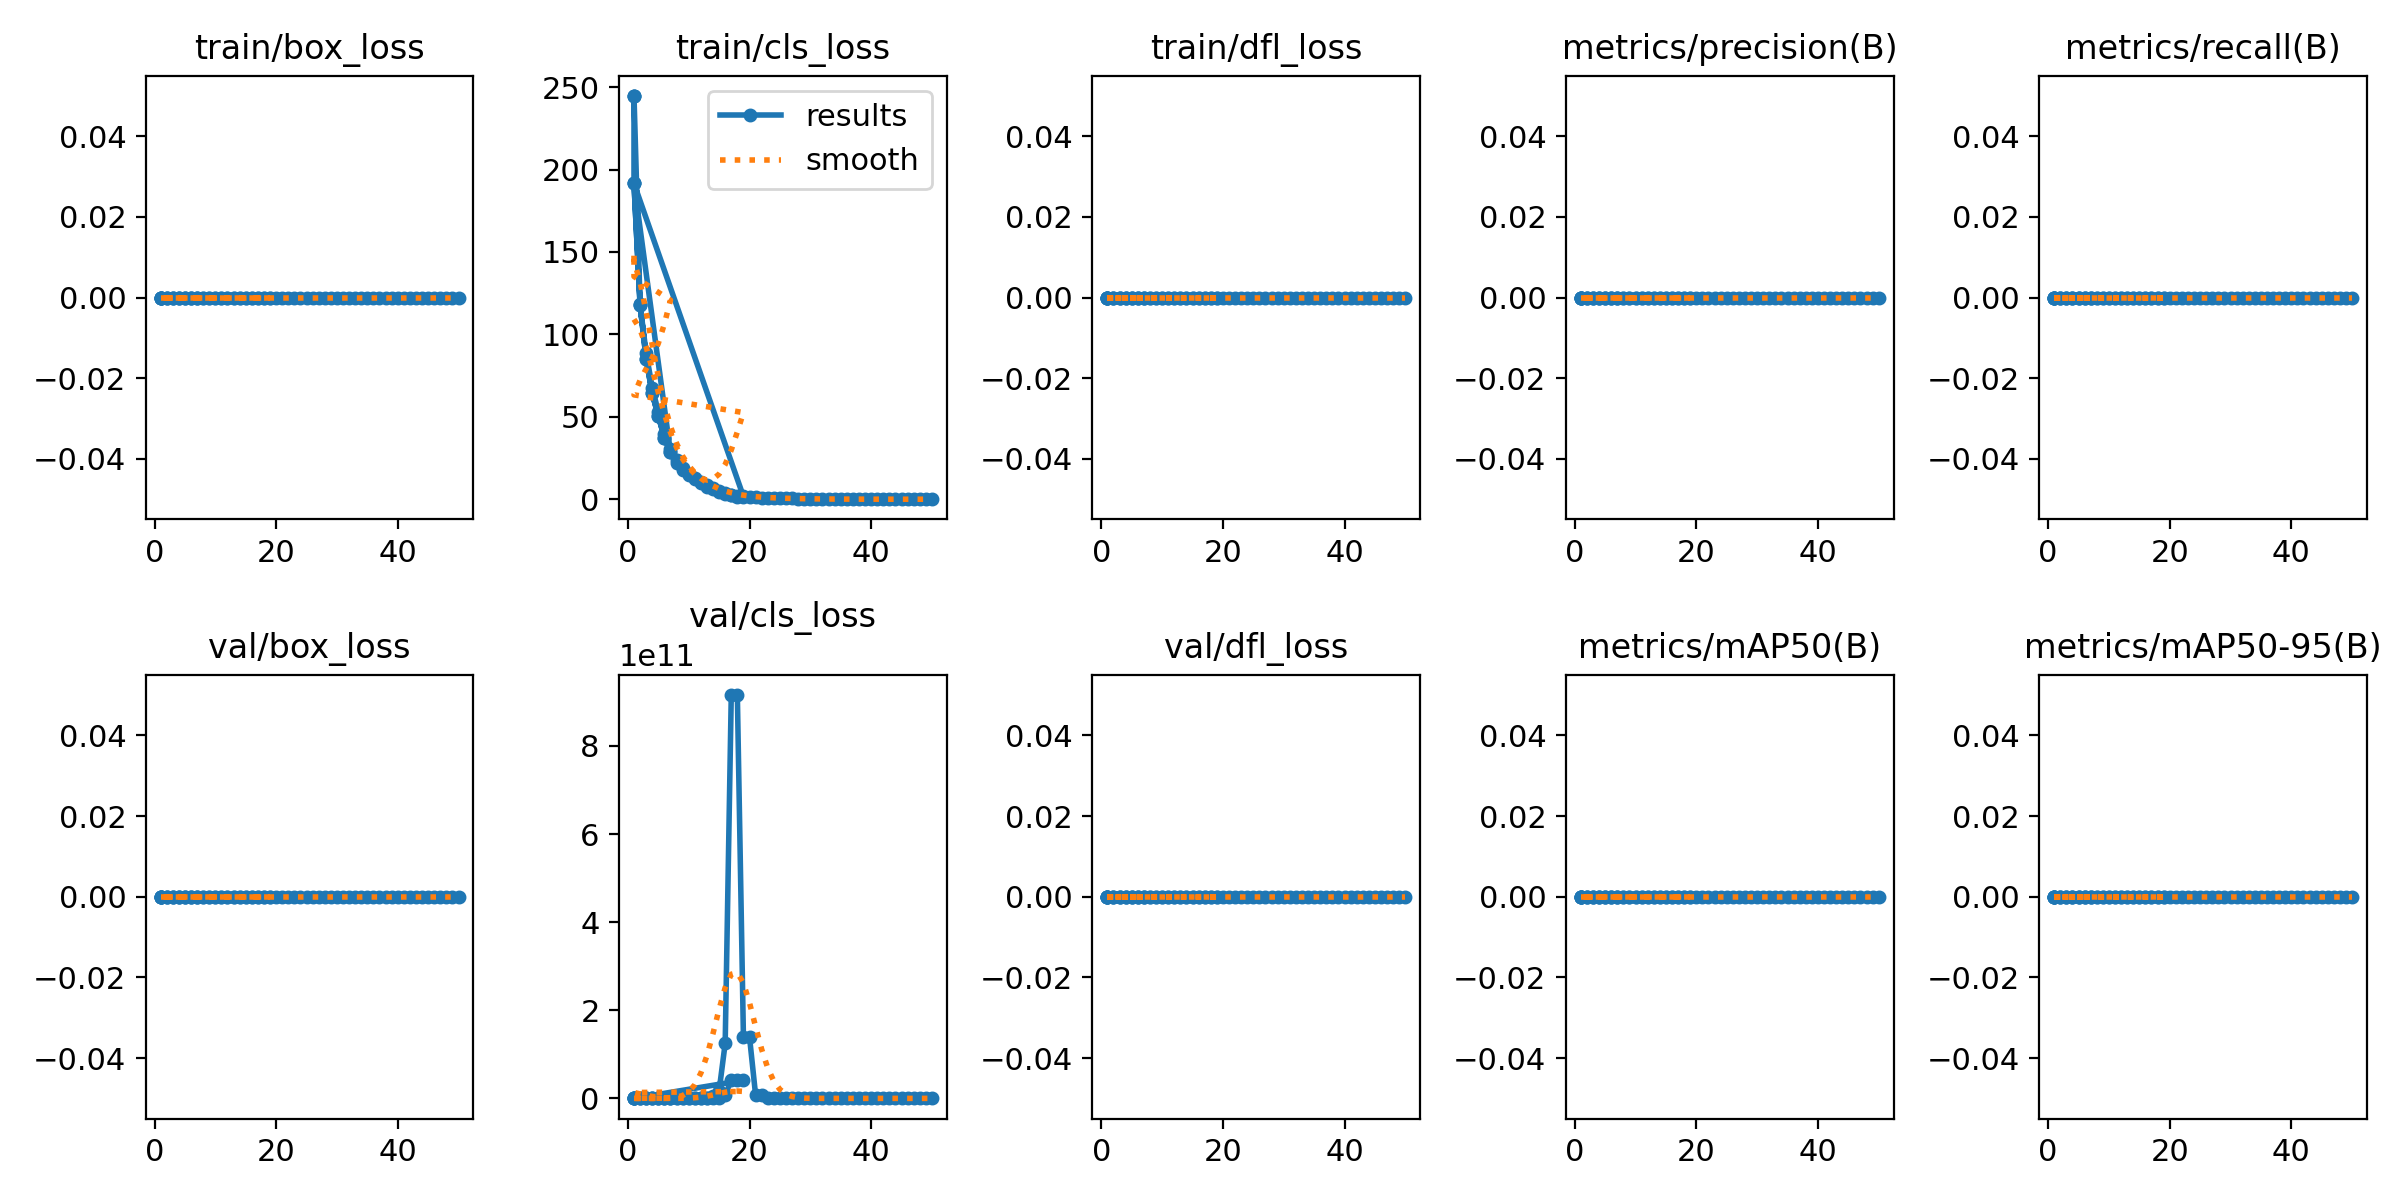


Confusion Matrix:


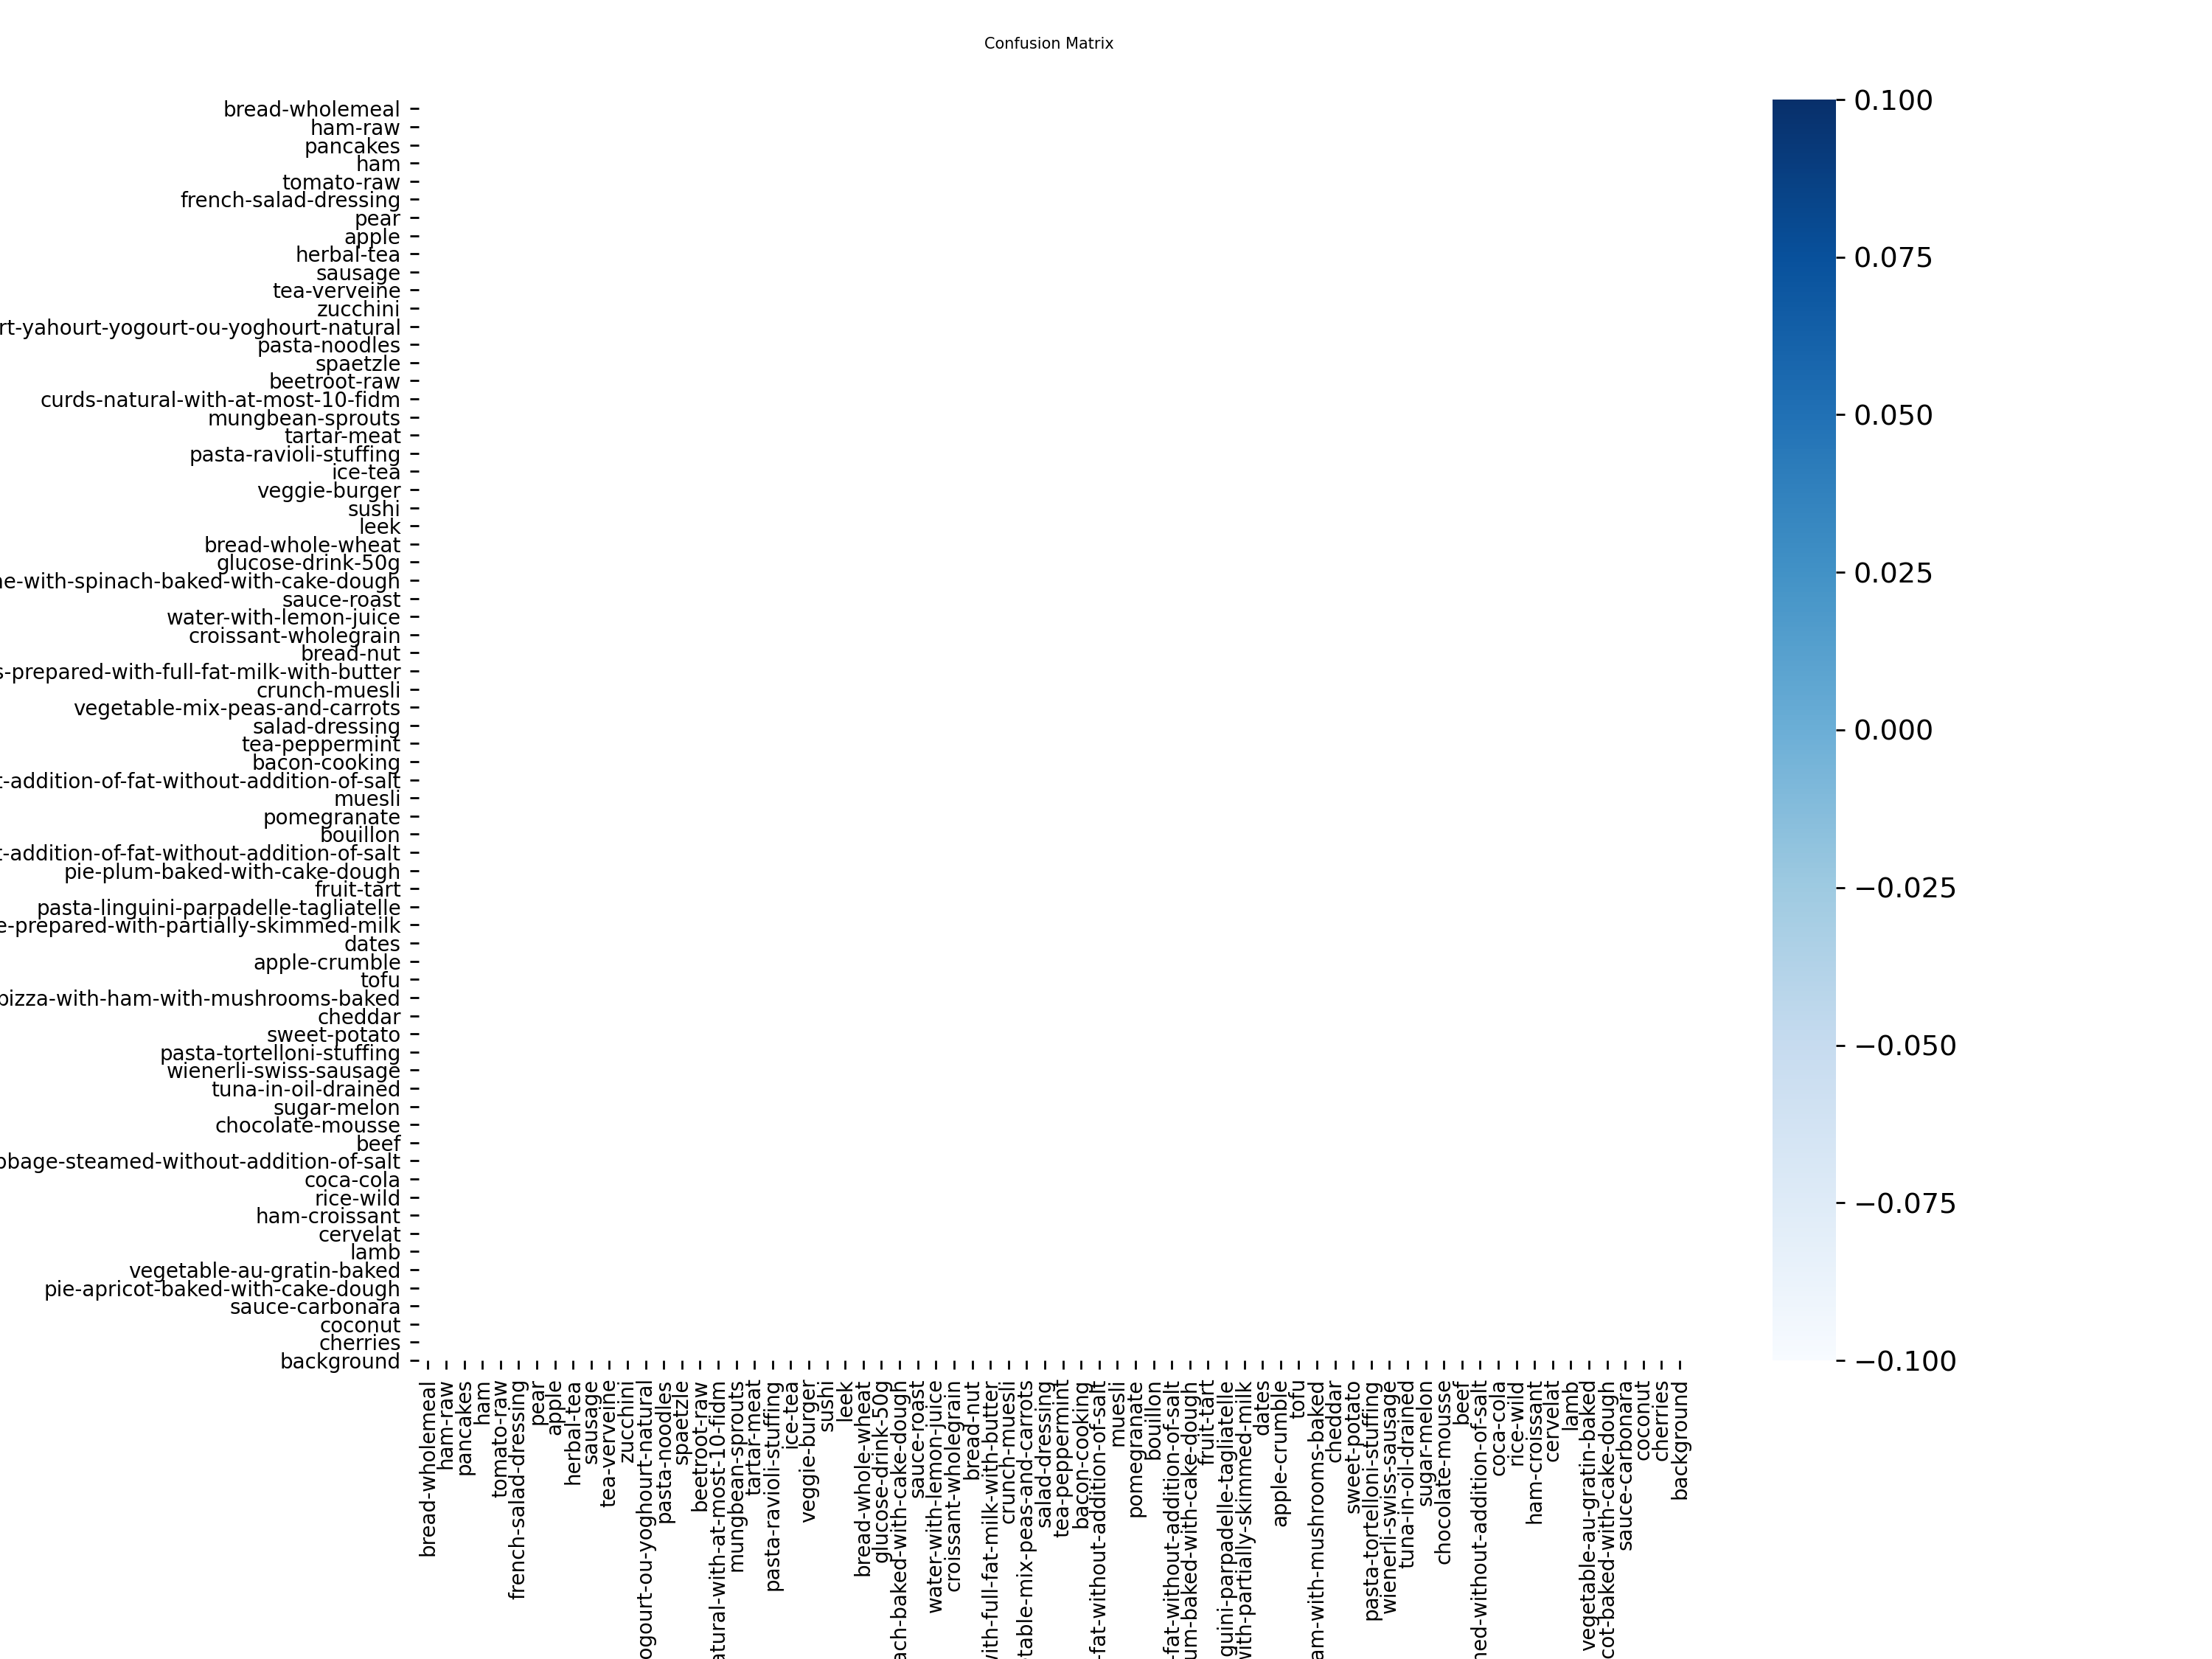

labels.jpg not found.

Validation Prediction Sample:


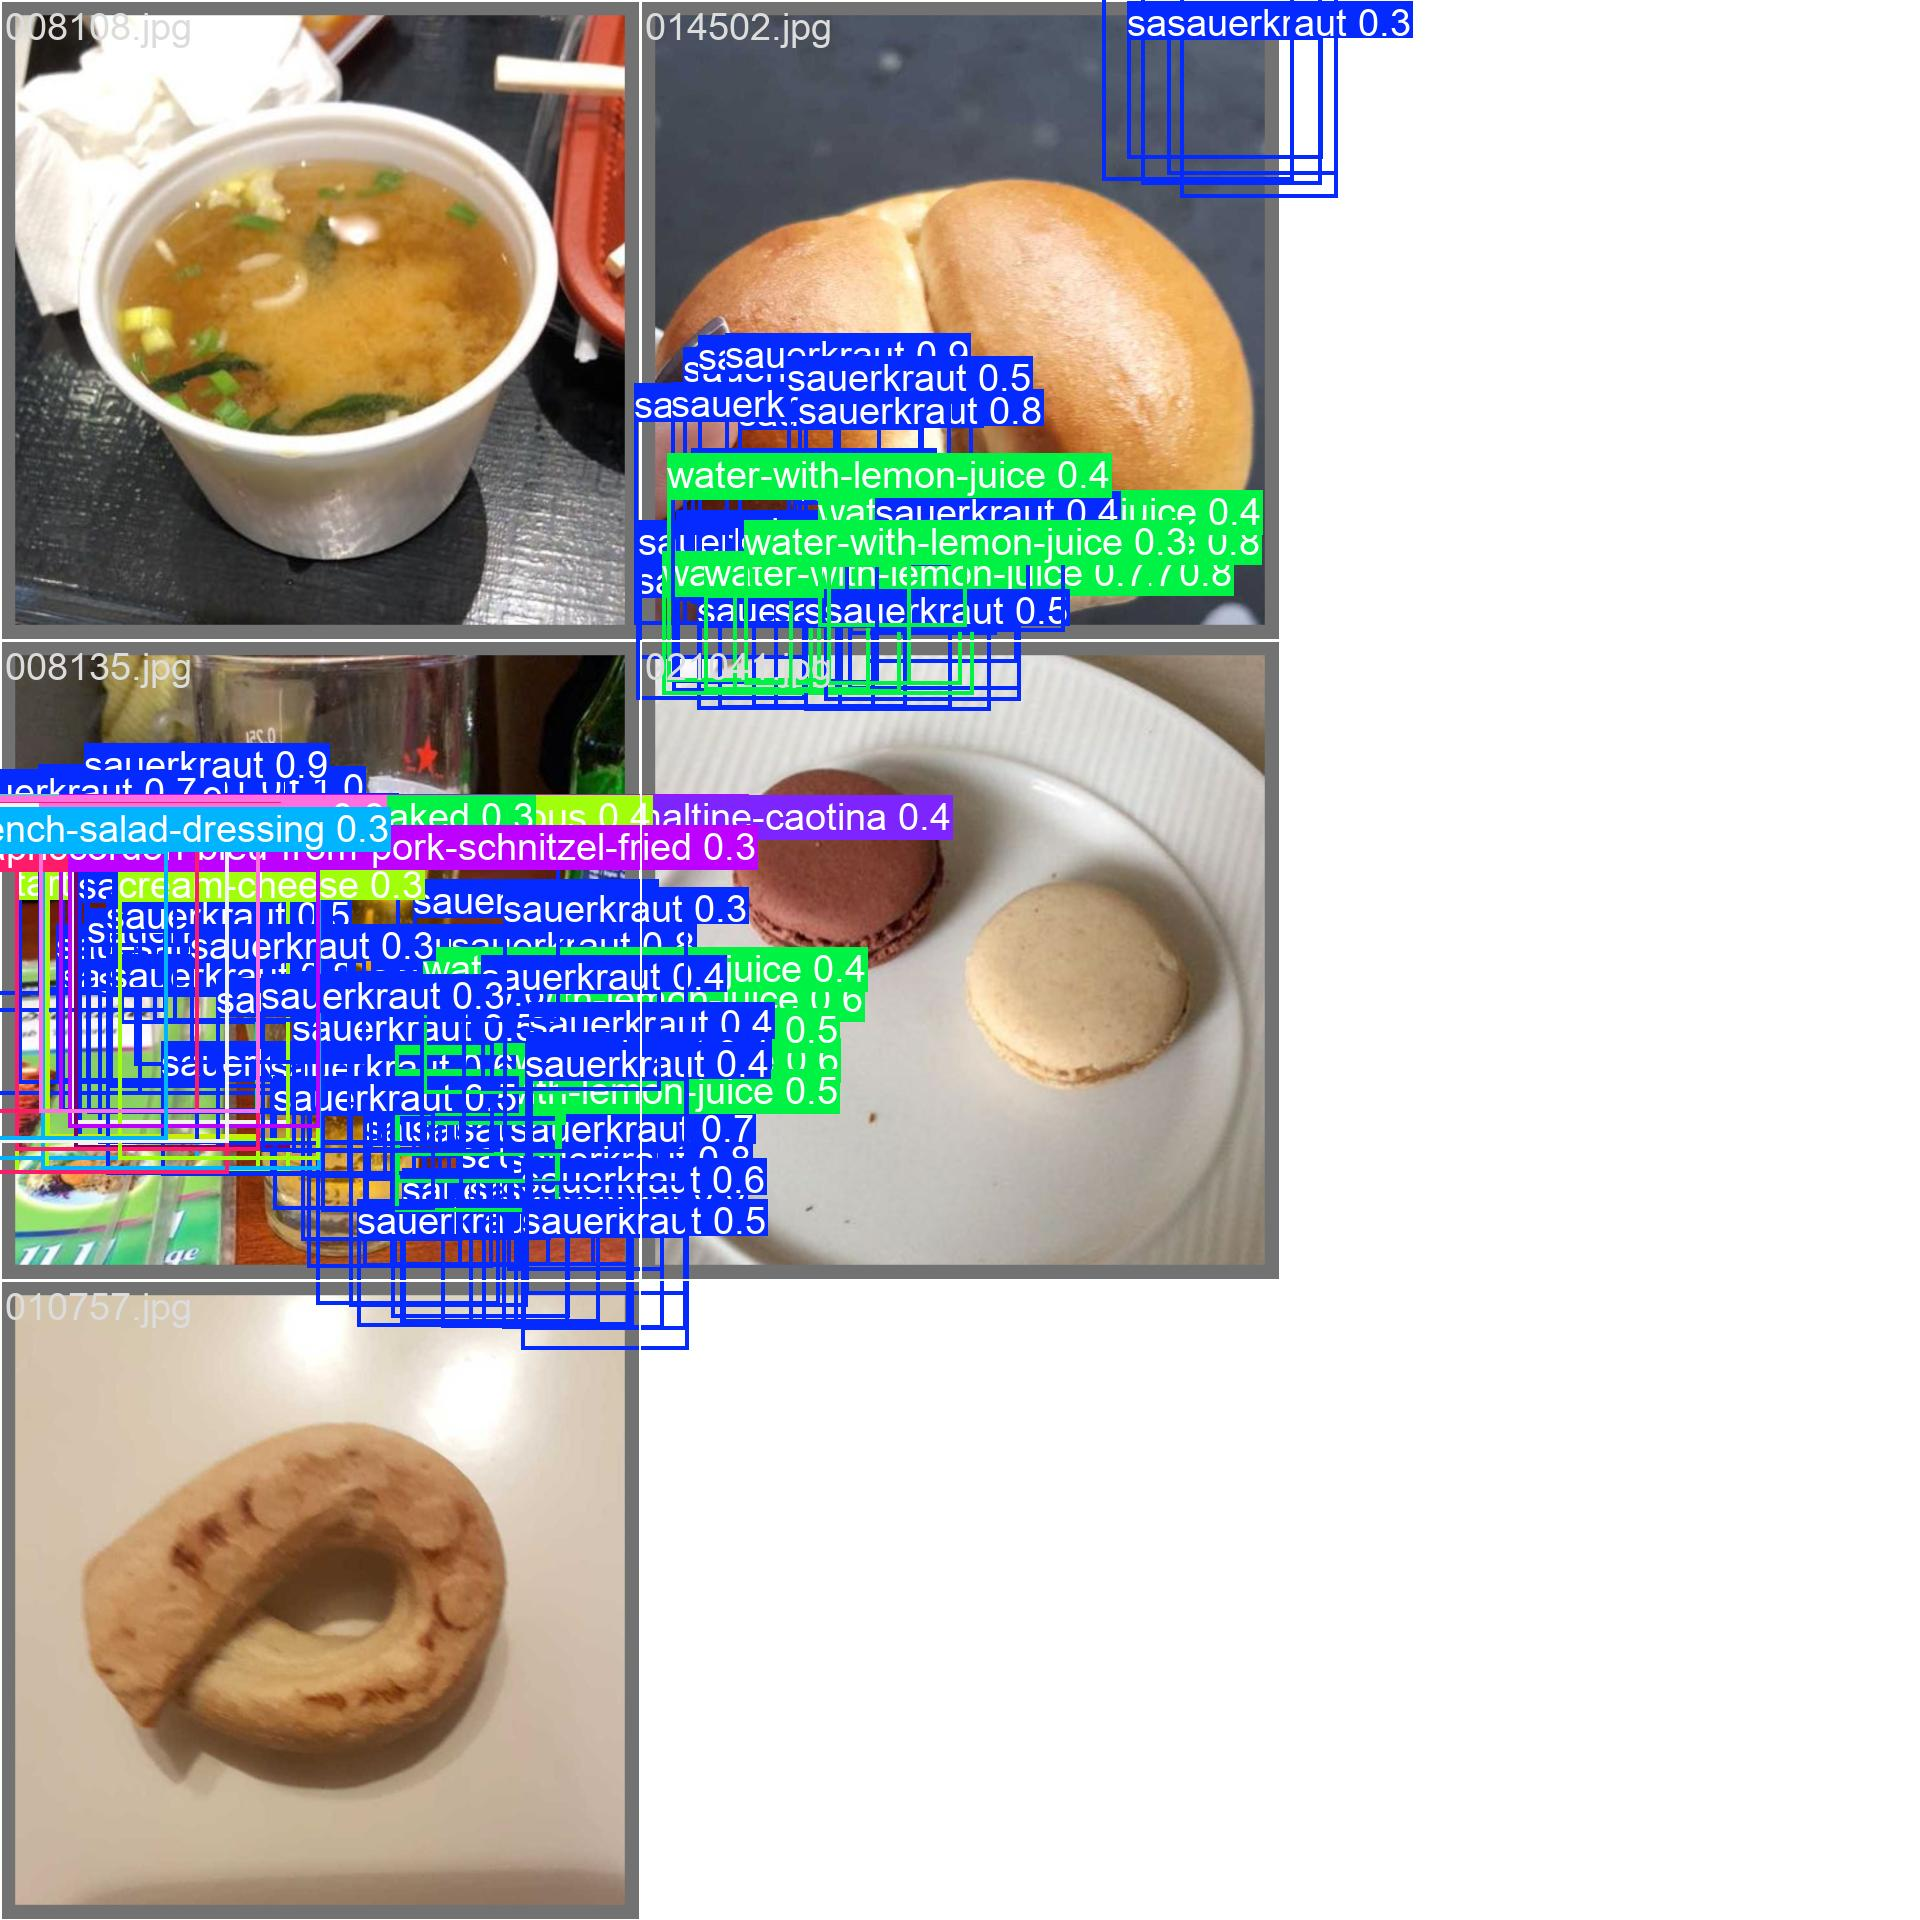

In [32]:
def main():
    
    dataset_path = "content/extracted_food_recognition" 
    trainer = FoodDetectionTrainer(dataset_path, model_size='s')  
    
    config = trainer.setup_training_config(
        epochs=2,    # small number for testing    
        batch_size=16,    
        image_size=640,   
        learning_rate=0.01,
        patience=30    
    )
    
    results = trainer.train(
        project_name='food_detection_project',
        experiment_name='food_410classes_v1'
    )
    
    val_results = trainer.evaluate()
    
    trainer.visualize_results()
    
    # Test prediction 
    # test_image = "/path/to/your/test/image.jpg"
    # if os.path.exists(test_image):
    #     trainer.test_prediction(test_image, confidence=0.3)
    
    return trainer

trainer = main()

In [ ]:
from google.colab import files

best_model = trainer.results.save_dir + "/weights/best.pt"

print(f"Downloading the best model for local use.')")

files.download(best_model)